In [1]:
!pip install rasterio h5py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 82.5 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import Huber
print(tf.__version__)


2025-05-03 09:52:39.772428: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746265959.946409      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746265959.997475      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [3]:
DATA_PATH = "/kaggle/input/data-rain-v2/DATA_RAIN_V2"
# ERA5_ATTRIBUTES = ["CAPE", "CIN", "EWSS", "IE", "ISOR", "KX", "PEV", "R250", "R500", "R850", "SLHF", "SLOR", "SSHF","TCLW","TCW","TCWV", "U250", "U850","V250", "V850"]
# HIMA_BANDS = ["B09B", "B10B", "B11B","B12B", "B14B", "B16B", "IRB", "I2B", "I4B", "WVB"]

ERA5_ATTRIBUTES = ["CAPE", "CIN", "R500", "TCLW","TCW","TCWV", "V250", "V850"]
HIMA_BANDS = ["B09B", "B11B","B12B", "B16B", "I4B", "WVB"]
print(len(ERA5_ATTRIBUTES ))
print(len(HIMA_BANDS))

8
6


# 1. Load dữ liệu

## 1.1. Hàm lấy file

In [4]:
def convert_time_to_strings(year, month, day, hour):
    year_str = str(year)
    month_str = f"{int(month):02d}"
    day_str = f"{int(day):02d}"
    hour_str = f"{int(hour):02d}"
    return year_str, month_str, day_str, hour_str

def get_era5_file_path(attribute, year, month, day, hour):
    year, month, day, hour = convert_time_to_strings(year, month, day, hour)
    file_name = f"ERA5_{attribute}_{year}_{month}_{day}_{hour}.tif"
    file_path = os.path.join(DATA_PATH, year, month, day, hour, "ERA5", file_name)
    return file_path


def get_hima_file_path(band, year, month, day, hour):
    year, month, day, hour = convert_time_to_strings(year, month, day, hour)
    file_name = f"Hima_{band}_{year}_{month}_{day}_{hour}.tif"
    file_path = os.path.join(DATA_PATH, year, month, day, hour, "Hima", file_name)
    return file_path

def get_radar_file_path(year, month, day, hour):
    year, month, day, hour = convert_time_to_strings(year, month, day, hour)
    file_name = f"Radar_{year}_{month}_{day}_{hour}.tif"
    file_path = os.path.join(DATA_PATH, year, month, day, hour, "Radar", file_name)
    return file_path

## 1.2. Load file

In [5]:
def load_era5_attributes(year, month, day, hour):
    era5_imgs= []
    for attribute in ERA5_ATTRIBUTES:
        file_path = get_era5_file_path(attribute, year, month, day, hour)
        try:
            with rasterio.open(file_path) as src:
                era5_imgs.append(src.read(1)) 
        except Exception as e:
            print(f"Failed to load {attribute} for {year}-{month}-{day} {hour}:00:00 {e}")
    era5_data = np.stack(era5_imgs, axis=-1)  
    return era5_data

def load_hima_bands(year, month, day, hour):
    hima_imgs = []
    for band in HIMA_BANDS:
        file_path = get_hima_file_path(band, year, month, day, hour)
        try:
            with rasterio.open(file_path) as src:
                hima_imgs.append(src.read(1))
        except Exception as e:
                print(f"Failed to load {band} for {year}-{month}-{day} {hour}:00:00 {e}")
    hima_data = np.stack(hima_imgs, axis = -1)
    return hima_data

def load_radar(year, month, day, hour):
    radar_img = None
    file_path = get_radar_file_path(year, month, day, hour)
    try: 
        with rasterio.open(file_path) as src:
            radar_img = src.read(1)
    except Exception as e:
        print(f"Failed to load radar for {year}-{month}-{day} {hour}:00:00 {e}")
    return radar_img

In [6]:
def load_data_for_timestamp(year, month, day, hour, use_era5 = True):
    try:
        era5_data = None
        if use_era5:
            era5_data = load_era5_attributes(year, month, day, hour)

        hima_data = load_hima_bands(year, month, day, hour)
        radar_data = load_radar(year, month, day, hour)
        if use_era5:
            input_images = np.concatenate((hima_data, era5_data), axis = -1) #shape (90, 250, hima + era5)
        else:
            input_images = hima_data

        return input_images, radar_data

    except Exception as e:
        print(f"Failed to load data for {year}-{month}-{day} {hour}:00:00 {e}")
        return None, None

In [7]:
def load_dataset(timestamps_df, use_era5 = True):
    X = []
    y = []
    timestamps_tuples = list(timestamps_df[['year', 'month', 'day', 'hour']].itertuples(index=False, name=None))
    for year, month, day, hour in tqdm(timestamps_tuples):
        input_images, radar_image = load_data_for_timestamp(year, month, day, hour, use_era5)
        if input_images is not None and radar_image is not None:
            X.append(input_images)
            y.append(radar_image)
    
    X = np.array(X)
    y = np.array(y)
    y = y[..., np.newaxis] #(90, 250, 1)
    return X, y

## 1.3. Chia dữ liệu

In [8]:
rain_df = pd.read_csv("/kaggle/input/valid-time-rain/final_rain_timestamps.csv", index_col=None)
rain_df.drop(columns = ['Unnamed: 0'], inplace = True)
train_df, tmp_df = train_test_split(
    rain_df, test_size = 0.3, stratify=rain_df["radar_mean_class"], random_state = 42
)

val_df, test_df = train_test_split(
    tmp_df, test_size=0.5, stratify=tmp_df["radar_mean_class"], random_state=42
)

## USE_ERA5

In [9]:
USE_ERA5 = True

## 1.4. Scale dữ liệu

In [10]:
X_train, y_train = load_dataset(train_df, USE_ERA5)
X_val, y_val = load_dataset(val_df, USE_ERA5)
X_test, y_test = load_dataset(test_df, USE_ERA5)

100%|██████████| 335/335 [01:11<00:00,  4.69it/s]


In [11]:
# np.savez_compressed('/kaggle/working/raindataset.npz', X_train=X_train, y_train=y_train, X_val = X_val, y_val = y_val, X_test = X_test, y_test = y_test)

In [12]:
y_train.max()

260.0

In [13]:
y_val.max()

231.0

In [14]:
y_test.max()

234.71875

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1]) #(num_sample * 250 * 90, hima + era5)
scaler_X.fit(X_train_reshaped)

X_train_scaled = scaler_X.transform(X_train_reshaped).reshape(X_train.shape)
X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Xử lý -inf

In [16]:
y_train = np.where(y_train < 0, -1, y_train)
y_val = np.where(y_val < 0, -1, y_val)
y_test = np.where(y_test < 0, -1, y_test)

# 2. Train

## 2.1. Tham số mô hình

In [17]:
BATCH_SIZE = 32
NUM_FILTERS = [64, 128, 256, 512]
BOTTLENECK_FILTER = 1024
EPOCHS = 100

## 2.2. Tạo mô hình

In [18]:
def inception_block(x, num_filters):
    config = {
        "conv1x1": num_filters // 8,
        "conv3x3_reduce": num_filters // 2,
        "conv3x3": num_filters // 2,
        "conv5x5_reduce": num_filters // 4,
        "conv5x5": num_filters // 4,
        "pool_proj": num_filters // 8,
    }

    # Branch 1: 1x1 conv
    branch1 = Conv2D(config["conv1x1"], kernel_size=1, padding='same')(x)
    branch1 = BatchNormalization()(branch1)
    branch1 = LeakyReLU(alpha=0.1)(branch1)

    # Branch 2: 1x1 conv -> 3x3 conv
    branch2 = Conv2D(config["conv3x3_reduce"], kernel_size=1, padding='same')(x)
    branch2 = LeakyReLU(alpha=0.1)(branch2)
    branch2 = Conv2D(config["conv3x3"], kernel_size=3, padding='same')(branch2)
    branch2 = BatchNormalization()(branch2)
    branch2 = LeakyReLU(alpha=0.1)(branch2)

    # Branch 3: 1x1 conv -> 5x5 conv
    branch3 = Conv2D(config["conv5x5_reduce"], kernel_size=1, padding='same')(x)
    branch3 = BatchNormalization()(branch3)
    branch3 = LeakyReLU(alpha=0.1)(branch3)
    branch3 = Conv2D(config["conv5x5"], kernel_size=5, padding='same')(branch3)
    branch3 = BatchNormalization()(branch3)
    branch3 = LeakyReLU(alpha=0.1)(branch3)

    # Branch 4: 3x3 maxpool -> 1x1 conv
    branch4 = MaxPooling2D(pool_size=3, strides=1, padding='same')(x)
    branch4 = Conv2D(config["pool_proj"], kernel_size=1, padding='same')(branch4)
    branch4 = BatchNormalization()(branch4)
    branch4 = LeakyReLU(alpha=0.1)(branch4)

    # Concatenate all branches
    output = Concatenate()([branch1, branch2, branch3, branch4])
    return output

def encoder_block(inputs, num_filters):
    x = inception_block(inputs, num_filters)
    p = MaxPooling2D(pool_size=(2, 2))(x)
    return x, p

# Decoder Block with residual connections
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, kernel_size=3, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = inception_block(x, num_filters)
    return x

In [19]:
def InceptionUnet(input_shape):
    inputs = Input(shape=input_shape, name="input")
    x = ZeroPadding2D(padding=((3, 3), (3, 3)))(inputs)  # Padding for even dimensions
    skip_connections = []
    

    for num_filters in NUM_FILTERS:
        skip, x = encoder_block(x, num_filters)
        skip_connections.append(skip)


    x = inception_block(x, BOTTLENECK_FILTER)


    skip_connections = skip_connections[::-1]
    for num_filters, skip in zip(NUM_FILTERS[::-1], skip_connections):
        x = decoder_block(x, skip, num_filters)


    x = Cropping2D(cropping=((3, 3), (3, 3)))(x)  # Crop padding
    outputs = Conv2D(1, kernel_size=1, padding='same', activation='relu')(x)
    

    model = Model(inputs, outputs)
    return model

In [20]:
channel = None
if USE_ERA5:
    channel = len(HIMA_BANDS) + len(ERA5_ATTRIBUTES)
else:
    channel = len(HIMA_BANDS)
    
input_shape = (90, 250, channel)
model = InceptionUnet(input_shape)
model.summary()

I0000 00:00:1746266406.142915      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 90, 250, 14)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 96, 256, 14)    │              0 │ input[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 96, 256, 16)    │            240 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 256, 32)    │            480 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 96, 256, 16)    │             64 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 96, 256, 32)    │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 96, 256, 16)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 96, 256, 14)    │              0 │ zero_padding2d[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 256, 8)     │            120 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 256, 32)    │          9,248 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 96, 256, 16)    │          6,416 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 96, 256, 8)     │            120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 96, 256, 8)     │             32 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 96, 256, 32)    │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 96, 256, 16)    │             64 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 96, 256, 8)     │             32 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 14,333,729 (54.68 MB)

 Trainable params: 14,326,369 (54.65 MB)

 Non-trainable params: 7,360 (28.75 KB)

## Train

## Metric Regression

In [21]:
from tensorflow.keras import backend as K

@tf.keras.utils.register_keras_serializable()
def create_non_negative_mask(y_true):
    return K.cast(K.greater_equal(y_true, 0), K.floatx())  # Mask where y_true >= 0


@tf.keras.utils.register_keras_serializable()    
def CC(y_true, y_pred):
    mask = create_non_negative_mask(y_true)
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask
    return K.mean((y_true_masked - K.mean(y_true_masked)) * 
                  (y_pred_masked - K.mean(y_pred_masked)) / 
                  (K.std(y_true_masked) * K.std(y_pred_masked) + K.epsilon()))
    
@tf.keras.utils.register_keras_serializable()
def R2(y_true, y_pred):
    mask = create_non_negative_mask(y_true)
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask
    ss_total = K.sum(K.square(y_true_masked - K.mean(y_true_masked)))
    ss_residual = K.sum(K.square(y_true_masked - y_pred_masked))
    return 1 - (ss_residual / (ss_total + K.epsilon()))
    
@tf.keras.utils.register_keras_serializable()
def custom_mse_loss(y_true, y_pred):
    mask = create_non_negative_mask(y_true)
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask
    squared_error = K.square(y_true_masked - y_pred_masked)
    return K.sum(squared_error) / (K.sum(mask) + K.epsilon())

@tf.keras.utils.register_keras_serializable()
def RMSE(y_true, y_pred):
    mask = create_non_negative_mask(y_true)
    y_true_masked = y_true * mask
    y_pred_masked = y_pred * mask
    squared_error = K.square(y_true_masked - y_pred_masked)
    mse = K.sum(squared_error) / (K.sum(mask) + K.epsilon())
    return K.sqrt(mse)

@tf.keras.utils.register_keras_serializable()
def weighted_sigmoid_mse(y_true, y_pred):
    scaling_factor=1
    threshold=0.05
    mask = create_non_negative_mask(y_true)
    y_norm = y_true / 260.0  # max y_train = 260
    weights = K.sigmoid(scaling_factor * (y_norm - threshold))  # Compute the weights using sigmoid
    weights_masked = weights * mask  
    y_true_masked = y_true * mask 
    y_pred_masked = y_pred * mask  
    squared_error = K.square(y_true_masked - y_pred_masked)  
    weighted_error = weights_masked * squared_error  # Apply weights
    return K.sum(weighted_error) / (K.sum(weights_masked) + K.epsilon())  # Normalize

## Metric classification

In [22]:
@tf.keras.utils.register_keras_serializable()
def create_missing_data_mask(y):
    return K.cast(K.less(y, 0), K.floatx()) # Mask where y == -1 (missing data)

# Mask for classifying values greater than or equal to 0.5
@tf.keras.utils.register_keras_serializable()
def create_class_mask(y):
    return K.cast(K.greater_equal(y, 0.5), K.floatx())

@tf.keras.utils.register_keras_serializable()
def FAR(y_true, y_pred):
    missing_mask = create_missing_data_mask(y_true)  # 1 where missing
    valid_mask = 1.0 - missing_mask  # 1 where valid

    y_true_class = create_class_mask(y_true)
    y_pred_class = create_class_mask(y_pred)

    # Only consider positions where valid_mask == 1
    FP = K.sum(K.cast((y_pred_class == 1) & (y_true_class == 0), K.floatx()) * valid_mask)
    TP = K.sum(K.cast((y_pred_class == 1) & (y_true_class == 1), K.floatx()) * valid_mask)

    far = FP / (TP + FP + K.epsilon())
    return far

@tf.keras.utils.register_keras_serializable()
def POD(y_true, y_pred):
    # Mask for missing data and valid values
    missing_mask = create_missing_data_mask(y_true)
    valid_mask = 1.0 - missing_mask

    # Convert to binary class masks
    y_true_class = create_class_mask(y_true)
    y_pred_class = create_class_mask(y_pred)


    TP = K.sum(K.cast((y_pred_class == 1) & (y_true_class == 1), K.floatx()) * valid_mask)
    FN = K.sum(K.cast((y_pred_class == 0) & (y_true_class == 1), K.floatx()) * valid_mask)

    pod = TP / (TP + FN + K.epsilon())
    return pod

@tf.keras.utils.register_keras_serializable()
def CSI(y_true, y_pred):
    # Create the missing data mask
    missing_mask = create_missing_data_mask(y_true)
    valid_mask = 1.0 - missing_mask

    # Convert to binary class masks
    y_true_class = create_class_mask(y_true)
    y_pred_class = create_class_mask(y_pred)

    # TP, FP, FN (only on valid data)
    TP = K.sum(K.cast((y_pred_class == 1) & (y_true_class == 1), K.floatx()) * valid_mask)
    FP = K.sum(K.cast((y_pred_class == 1) & (y_true_class == 0), K.floatx()) * valid_mask)
    FN = K.sum(K.cast((y_pred_class == 0) & (y_true_class == 1), K.floatx()) * valid_mask)

    csi = TP / (TP + FP + FN + K.epsilon())
    return csi

## Train .fit

In [23]:
optimizer = Adam(learning_rate=0.001)

# Callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True, verbose=1)

# Compile Model
model.compile(optimizer=optimizer, 
              loss=weighted_sigmoid_mse, 
              metrics=[RMSE, CC, R2, POD, FAR, CSI])

# Train Model
history = model.fit(X_train_scaled, y_train,
                    batch_size=32,
                    epochs=100,
                    verbose=1,
                    validation_data=(X_val_scaled, y_val),
                    callbacks=[checkpoint, reduce_lr, early_stopping])

Epoch 1/100


I0000 00:00:1746266458.049163      65 service.cc:148] XLA service 0x790d38002570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746266458.049860      65 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746266461.795677      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746266502.478738      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - cc: 0.2668 - csi: 0.1865 - far: 0.7667 - loss: 5.4743 - pod: 0.5655 - r2: 0.0428 - rmse: 1.7940   
Epoch 1: val_loss improved from inf to 2.52240, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - cc: 0.2680 - csi: 0.1874 - far: 0.7656 - loss: 5.4538 - pod: 0.5652 - r2: 0.0438 - rmse: 1.7912 - val_cc: 0.1787 - val_csi: 0.1100 - val_far: 0.8611 - val_loss: 2.5224 - val_pod: 0.3483 - val_r2: -0.1105 - val_rmse: 1.4756 - learning_rate: 0.0010
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - cc: 0.3277 - csi: 0.2333 - far: 0.7103 - loss: 4.3530 - pod: 0.5527 - r2: 0.0896 - rmse: 1.6742
Epoch 2: val_loss improved from 2.52240 to 2.35031, saving model to best_model.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 360ms/step - cc: 0.3278 - csi: 0.2334 - far: 0.7102 - loss: 4.3538 - pod: 0.5529 - r2: 0.0895 - rmse: 1.6737 - val_cc: 0.3054 - val_csi: 0.0689 - val_far: 0.2856 - val_loss: 2.3503 - val_pod: 0.0709 - val_r2: 0.0193 - val_rm

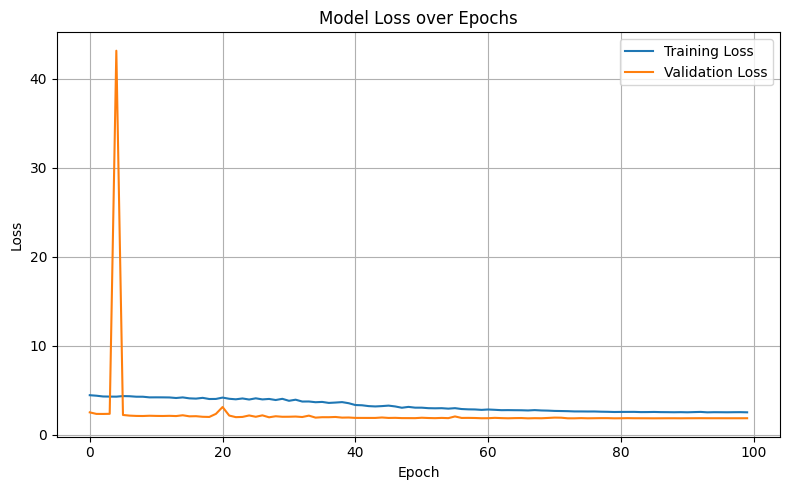

In [24]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Metric valid set

In [25]:
best_epoch = np.argmin(history.history['val_loss'])

# Print all metrics for that epoch
print(f"Best Epoch: {best_epoch + 1}")
for metric in history.history.keys():
    print(f"{metric}: {history.history[metric][best_epoch]:.4f}")

Best Epoch: 67
cc: 0.6103
csi: 0.3180
far: 0.6004
loss: 2.7369
pod: 0.6061
r2: 0.3863
rmse: 1.3342
val_cc: 0.4755
val_csi: 0.3052
val_far: 0.6226
val_loss: 1.8523
val_pod: 0.6155
val_r2: 0.2187
val_rmse: 1.2421
learning_rate: 0.0001


In [26]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix
from scipy.stats import pearsonr
from tensorflow.keras.models import load_model


## Metric test set

In [27]:
best_model = load_model('/kaggle/working/best_model.keras')
y_test_pred = best_model.predict(X_test_scaled)
y_test_pred_flat = y_test_pred.flatten()
y_test_flat = y_test.flatten()

# Mask to exclude missing data 
mask = y_test_flat >= 0

# Apply mask to filter out missing data
y_test_flat_filtered = y_test_flat[mask]
y_test_pred_flat_filtered = y_test_pred_flat[mask]

mse = mean_squared_error(y_test_flat_filtered, y_test_pred_flat_filtered)
rmse = np.sqrt(mse)
cc, _ = pearsonr(y_test_flat_filtered, y_test_pred_flat_filtered)
r2 = r2_score(y_test_flat_filtered, y_test_pred_flat_filtered)

print("Test set")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"Correlation Coefficient (CC): {cc}")
print(f"R²: {r2}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step
Test set
MSE: 1.9194822311401367
RMSE: 1.3854538202285767
Correlation Coefficient (CC): 0.48660042881965637
R²: 0.22959655687233826


In [28]:
from sklearn.metrics import confusion_matrix
true_class_mask = y_test_flat >= 0.5
pred_class_mask = y_test_pred_flat >= 0.5


true_class_mask = np.where(mask, true_class_mask, -1)
pred_class_mask = np.where(mask, pred_class_mask, -1)

valid_mask = (true_class_mask != -1) & (pred_class_mask != -1)
true_class_mask_filtered = true_class_mask[valid_mask]
pred_class_mask_filtered = pred_class_mask[valid_mask]
cm = confusion_matrix(true_class_mask_filtered, pred_class_mask_filtered)

# If cm is a 2x2 matrix, unpack it
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
else:
    # Handle cases where there's no confusion matrix (only one class present)
    tn = cm[0, 0] if cm.shape[0] > 1 else 1
    fp = cm[0, 1] if cm.shape[1] > 1 else 0
    fn = cm[1, 0] if cm.shape[0] > 1 else 0
    tp = cm[1, 1] if cm.shape[1] > 1 else 1

far = fp / (tp + fp) if (tp + fp) > 0 else 0.0

# Probability of Detection (POD) = TP / (TP + FN)
pod = tp / (tp + fn) if (tp + fn) > 0 else 0.0

# Critical Success Index (CSI) = TP / (TP + FP + FN)
csi = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

# Print the metrics
print(f"FAR: {far}")
print(f"POD: {pod}")
print(f"CSI: {csi}")

FAR: 0.6041706110664079
POD: 0.6408588657339777
CSI: 0.323965657504794


## Plot

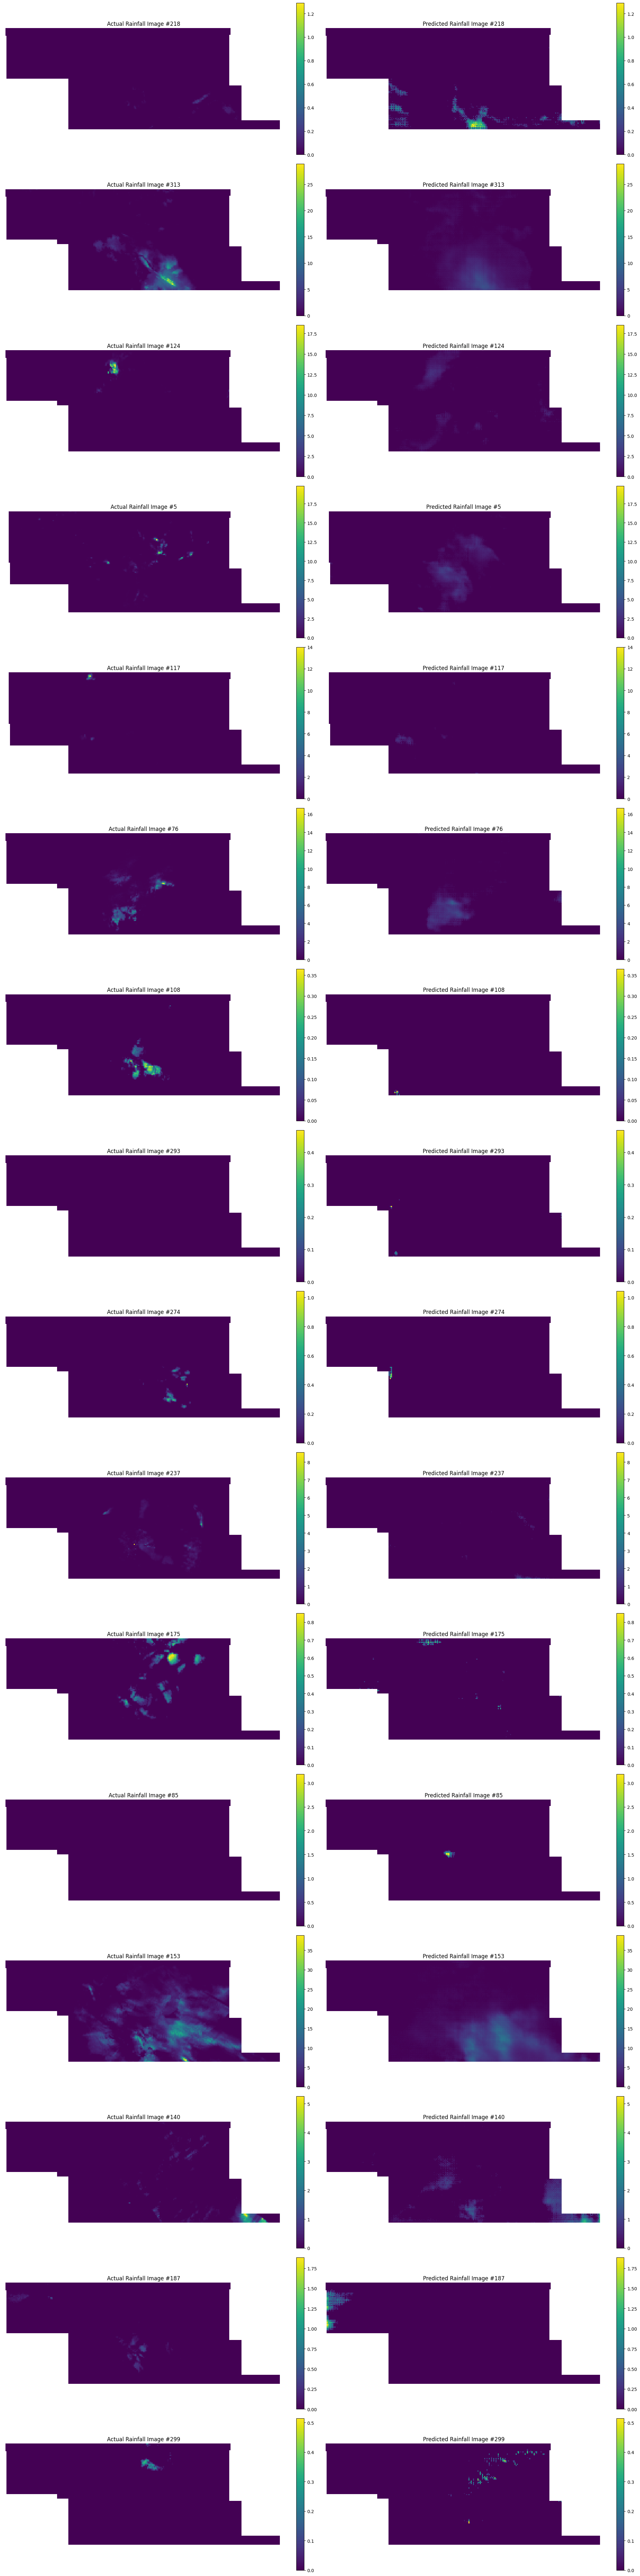

In [29]:
num_examples = 16  # Number of examples to visualize
plt.figure(figsize=(20, 5 * num_examples))
random_indices = np.random.choice(len(y_test), size=num_examples, replace=False)
np.random.seed(42)
for i, index in enumerate(random_indices):
    
    predicted_image = y_test_pred[index]
    radar_image = y_test[index]
    
    mask = radar_image >= 0
    predicted_image[~mask] = -np.inf
    radar_image[~mask] = -np.inf
    vmin = 0
    vmax_true = np.max(radar_image)
    vmax_pred = np.max(predicted_image)
    vmax = np.max([vmax_true, vmax_pred])

    plt.subplot(num_examples, 2, i * 2 + 1)
    im1 = plt.imshow(radar_image, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'Actual Rainfall Image #{index}', fontsize=12)
    plt.axis('off')
    plt.colorbar(im1, fraction=0.046, pad=0.04)

    # Plot predicted image
    plt.subplot(num_examples, 2, i * 2 + 2)
    im2 = plt.imshow(predicted_image, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Rainfall Image #{index}', fontsize=12)
    plt.axis('off')
    plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

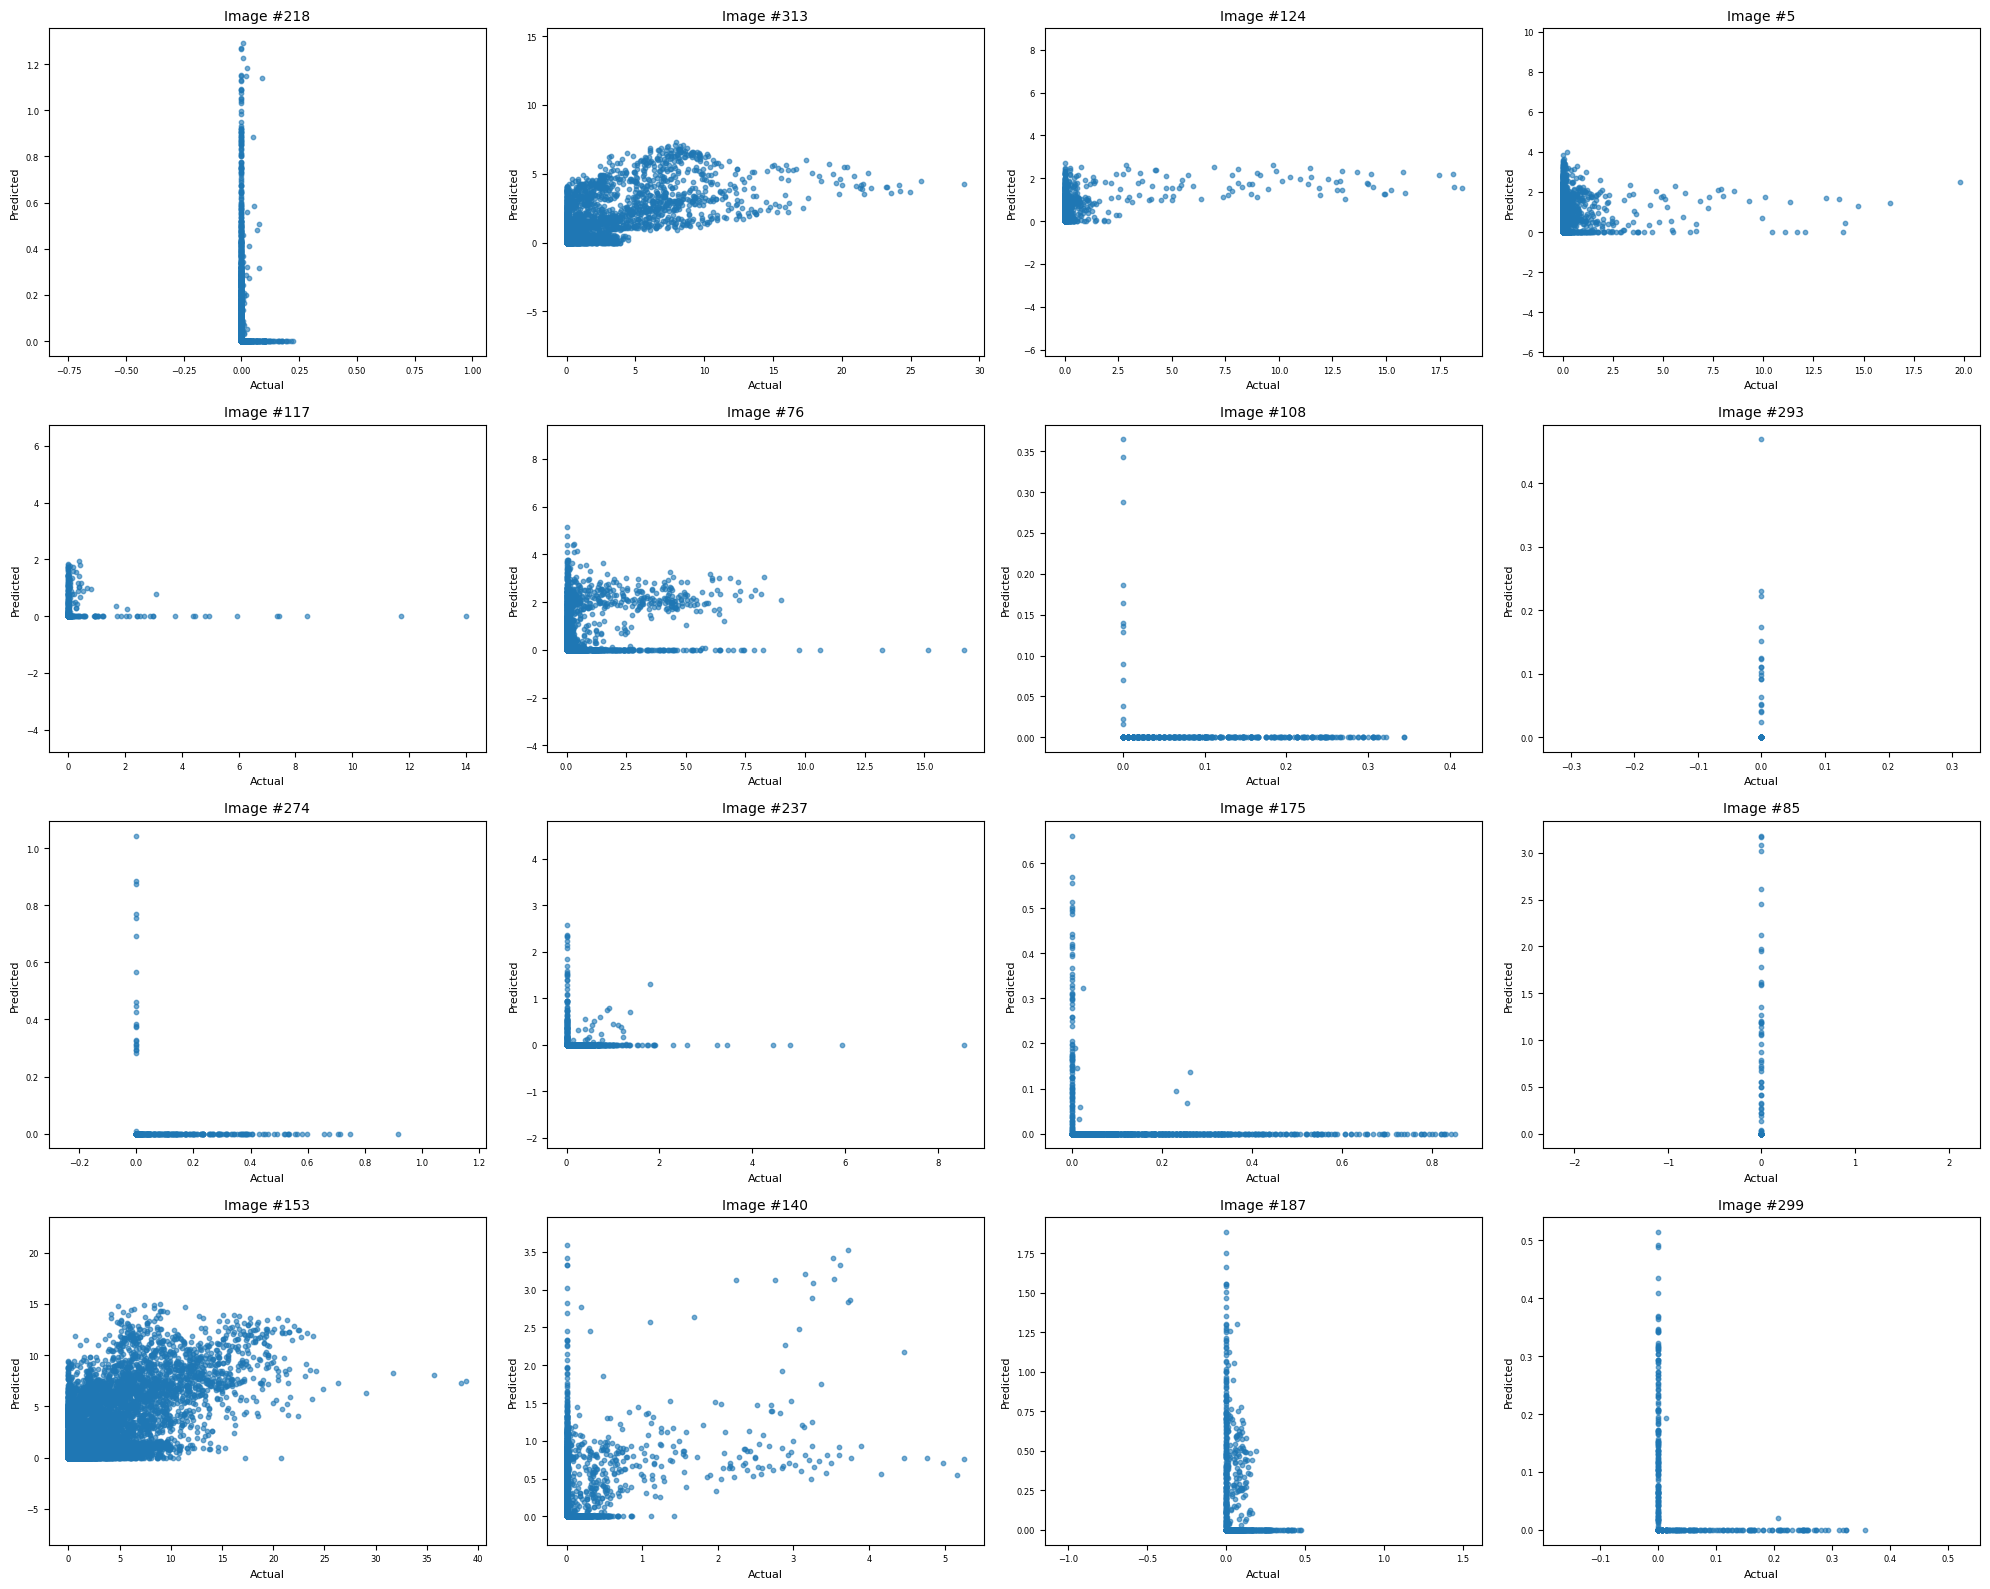

In [30]:
num_examples = len(random_indices)
cols = 4
rows = (num_examples + cols - 1) // cols

plt.figure(figsize=(cols * 5, rows * 4))  # Adjust size as needed

for i, index in enumerate(random_indices):
    predicted_image = y_test_pred[index]
    radar_image = y_test[index]
    
    # Mask invalid values
    mask = radar_image >= 0
    predicted_image = predicted_image[mask]
    radar_image = radar_image[mask]
    
    # Scatter plot
    plt.subplot(rows, cols, i + 1)
    plt.scatter(radar_image.flatten(), predicted_image.flatten(), alpha=0.6, s=10)
    plt.title(f'Image #{index}', fontsize=10)
    plt.xlabel('Actual', fontsize=8)
    plt.ylabel('Predicted', fontsize=8)
    plt.axis('equal')
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

## Plot val

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


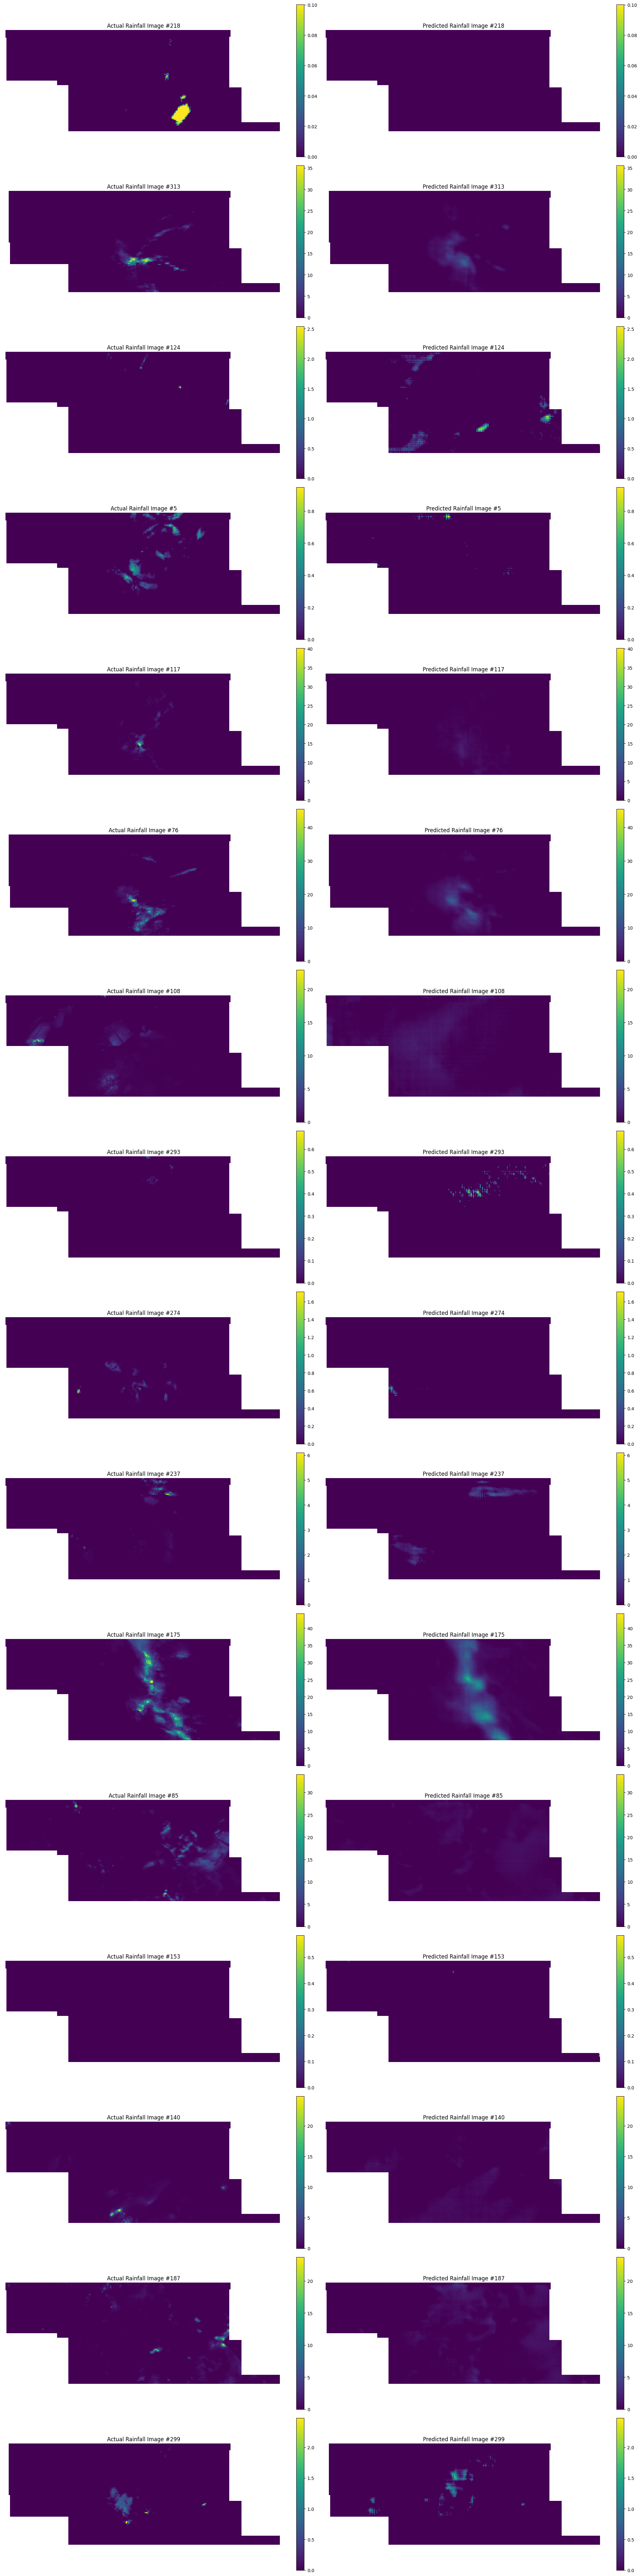

In [31]:
y_val_pred = best_model.predict(X_val_scaled)

plt.figure(figsize=(20, 5 * num_examples))
for i, index in enumerate(random_indices):
    
    predicted_image = y_val_pred[index]
    radar_image = y_val[index]
    
    mask = radar_image >= 0
    predicted_image[~mask] = -np.inf
    radar_image[~mask] = -np.inf
    vmin = 0
    vmax_true = np.max(radar_image)
    vmax_pred = np.max(predicted_image)
    vmax = np.max([vmax_true, vmax_pred])

    plt.subplot(num_examples, 2, i * 2 + 1)
    im1 = plt.imshow(radar_image, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'Actual Rainfall Image #{index}', fontsize=12)
    plt.axis('off')
    plt.colorbar(im1, fraction=0.046, pad=0.04)

    # Plot predicted image
    plt.subplot(num_examples, 2, i * 2 + 2)
    im2 = plt.imshow(predicted_image, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Rainfall Image #{index}', fontsize=12)
    plt.axis('off')
    plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

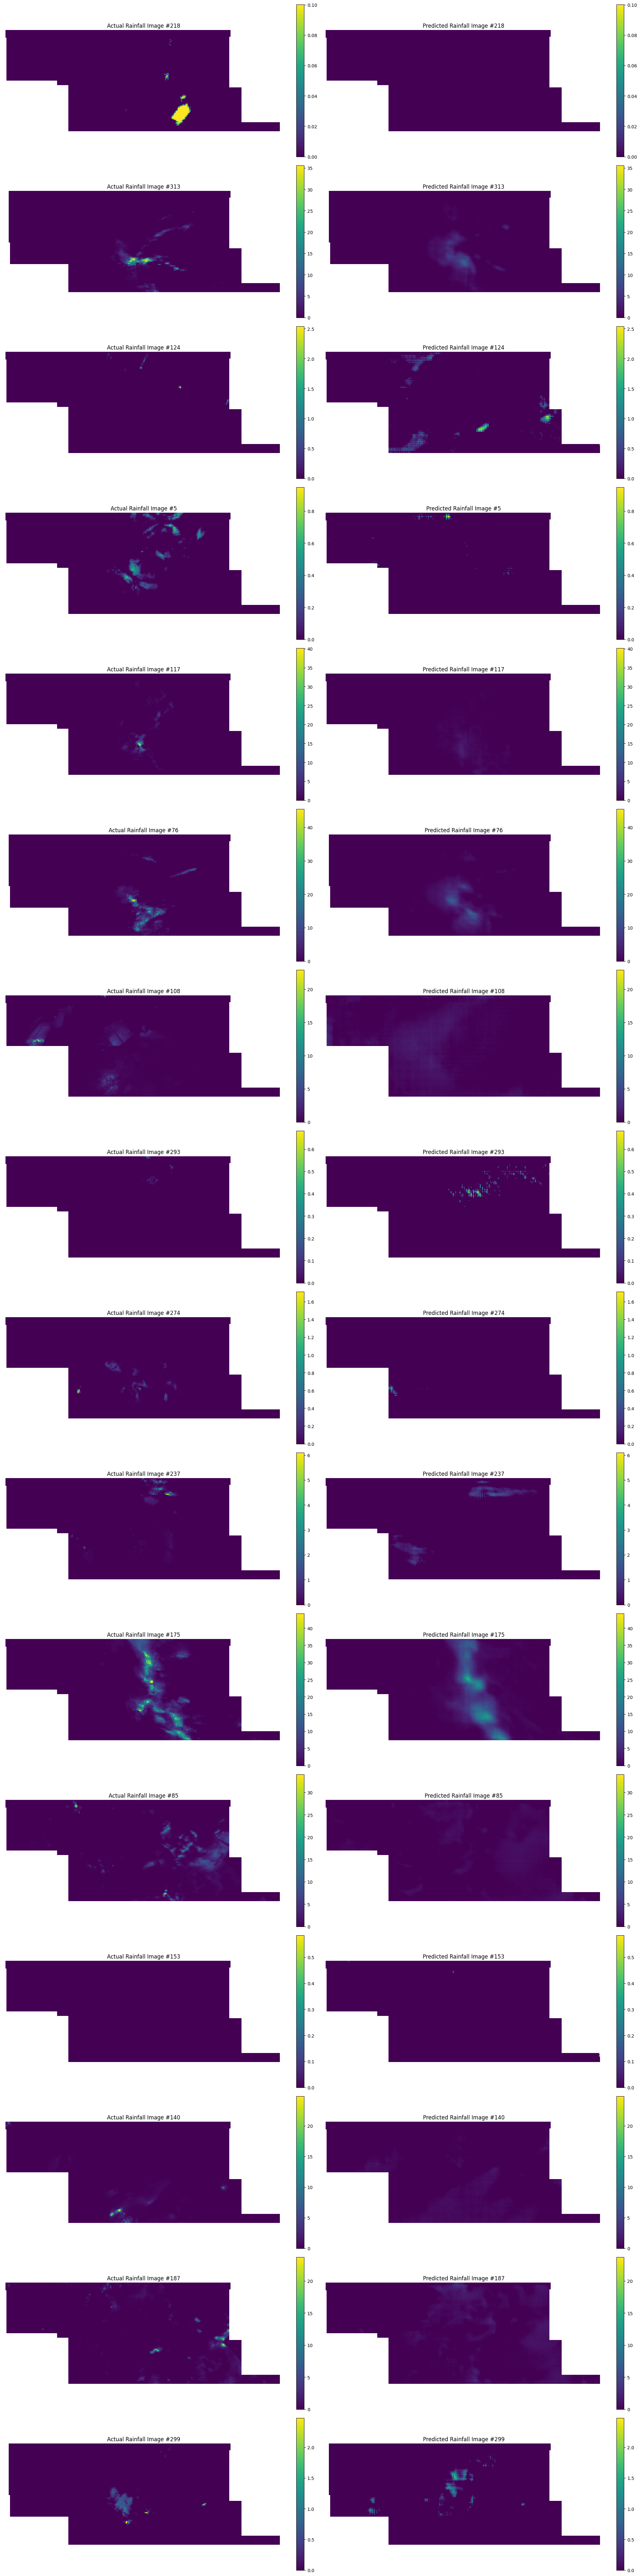

In [32]:
plt.figure(figsize=(20, 5 * num_examples))
for i, index in enumerate(random_indices):
    
    predicted_image = y_val_pred[index]
    radar_image = y_val[index]
    
    mask = radar_image >= 0
    radar_image[~mask] = -np.inf
    vmin = 0
    vmax_true = np.max(radar_image)
    vmax_pred = np.max(predicted_image)
    vmax = np.max([vmax_true, vmax_pred])

    plt.subplot(num_examples, 2, i * 2 + 1)
    im1 = plt.imshow(radar_image, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'Actual Rainfall Image #{index}', fontsize=12)
    plt.axis('off')
    plt.colorbar(im1, fraction=0.046, pad=0.04)

    # Plot predicted image
    plt.subplot(num_examples, 2, i * 2 + 2)
    im2 = plt.imshow(predicted_image, cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Rainfall Image #{index}', fontsize=12)
    plt.axis('off')
    plt.colorbar(im2, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()